<a href="https://colab.research.google.com/github/LorenzEh/Tweet-Classification/blob/main/LLM_Party_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing libraries and basic data exploration

In [94]:
!pip install transformers datasets tiktoken

In [95]:
from importlib.metadata import version
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import pandas as pd

In [96]:
dataframe = pd.read_parquet("hf://datasets/Jacobvs/PoliticalTweets/formatted_data.parquet")

In [97]:
dataframe.head(10)

,date,id,username,text,party,labels
index,,,,,,
0,2021-10-13 19:47:44,1448374915636383745,SenatorHassan,Happy th birthday to the @USNavy! The strength...,Democrat,1
1,2021-06-30 14:53:13,1410250073003462656,SenatorMenendez,The greatest generation's investment in infras...,Democrat,1
2,2021-08-08 01:11:29,1424176405881966599,SenBillCassidy,"Thanks to @SenTedCruz and @SenatorWarnock, th...",Republican,0
3,2021-04-14 14:02:49,1382333523567185921,SenBlumenthal,/ To get lasting change we cant just lock up t...,Democrat,1
4,2021-12-11 16:06:38,1469700160934621188,SenatorBraun,Today were celebrating years of the Hoosier st...,Republican,0
5,2021-05-11 17:18:50,1392167324401143812,SenJeffMerkley,The #ForthePeopleAct includes reforms that are...,Democrat,1
6,2021-08-10 16:22:55,1425130548620578816,SenBlumenthal,"Todays strong, bipartisan vote is just the beg...",Democrat,1
7,2021-08-12 01:13:26,1425626448518385664,SenatorHagerty,Supporting crime victims requires holding crim...,Republican,0
8,2021-12-11 16:27:51,1469705498224209928,SenBillCassidy,We in Louisiana know how natural disasters cha...,Republican,0


In [98]:
nr = 1
print("Exmaple Tweet:")
print(dataframe["text"][nr])
print("Party:")
print(dataframe["party"][nr])


print("\nFrom:")
print(dataframe["date"].min())

print("\nTo:")
print(dataframe["date"].max())


Exmaple Tweet:
The greatest generation's investment in infrastructure made us the envy of the world. But now we've gone almost an entire lifetime without making any significant investments in the NEXT generation of American infrastructure. It's time for that to change. https://t.co/brikl79Kgp
Party:
Democrat

From:
2016-09-28 04:16:02

To:
2023-02-19 23:32:00


# Data Preparation
Data preparation involves the following steps:

- Splitting the balanced dataset into training, validation, and test sets while preserving class distribution in each split. Additionally: concat the remaining tweets in a dataframe, which can be later used to check how the model behaves (additionally to the testing data).
- Saving the split datasets to CSV files for later use.

Introducing text normalization could be considered here, although it could lead to a loss of information (for example the usage of capslock for expressing hrad feelings about something)

In [99]:
# we limit the dataset and make sure it has the same number of democratic and republican tweets in each datatset, we keep the remaining tweets for later
# training the model with all the data availabe would be better, but isn't really feasible with limited ressources.

def balance_and_split_dataset(df, train_frac, validation_frac, sample_size=50000, random_state=None):
    if random_state is not None:
        torch.manual_seed(random_state)

    # first, create the balanced subset of sample_size from the original dataframe
    democrat_df = df[df["party"] == "Democrat"].copy()
    republican_df = df[df["party"] == "Republican"].copy()

    min_samples = min(len(democrat_df), len(republican_df), sample_size // 2)
    if min_samples * 2 < sample_size:
         print(f"Warning: Not enough samples to create a balanced dataset of size {sample_size}. Using size {min_samples * 2} instead.")
         sample_size = min_samples * 2

    # get the original indices of the sampled tweets for the balanced subset
    democrat_sample_indices = democrat_df.sample(n=sample_size // 2, random_state=random_state, replace=False).index
    republican_sample_indices = republican_df.sample(n=sample_size // 2, random_state=random_state, replace=False).index

    # create the balanced subset dataframe using the original indices
    balanced_subset_indices = democrat_sample_indices.union(republican_sample_indices)
    balanced_subset_df = df.loc[balanced_subset_indices].sample(frac=1, random_state=random_state).reset_index(drop=True) # Shuffle the balanced subset

    # split the balanced subset dataframe into train, validation, and test
    total_balanced = len(balanced_subset_df)
    train_count = int(total_balanced * train_frac)
    validation_count = int(total_balanced * validation_frac)
    test_count = total_balanced - train_count - validation_count # The rest goes to test

    # split the balanced subset while maintaining balance within each split
    # separate into Democrat and Republican within the balanced subset
    balanced_democrat_df = balanced_subset_df[balanced_subset_df["party"] == "Democrat"].copy()
    balanced_republican_df = balanced_subset_df[balanced_subset_df["party"] == "Republican"].copy()

    # calculate counts for each split per party
    train_democrat_count_split = int(len(balanced_democrat_df) * train_frac)
    validation_democrat_count_split = int(len(balanced_democrat_df) * validation_frac)
    test_democrat_count_split = len(balanced_democrat_df) - train_democrat_count_split - validation_democrat_count_split

    train_republican_count_split = int(len(balanced_republican_df) * train_frac)
    validation_republican_count_split = int(len(balanced_republican_df) * validation_frac)
    test_republican_count_split = len(balanced_republican_df) - train_republican_count_split - validation_republican_count_split


    # sample for each split from the balanced subset, maintaining balance
    train_democrat_sample = balanced_democrat_df.sample(n=train_democrat_count_split,random_state=random_state, replace=False)
    remaining_democrat_split = balanced_democrat_df.drop(train_democrat_sample.index)
    validation_democrat_sample = remaining_democrat_split.sample(n=validation_democrat_count_split, random_state=random_state, replace=False)
    test_democrat_sample = remaining_democrat_split.drop(validation_democrat_sample.index).sample(n=test_democrat_count_split,
                                                                                                  random_state=random_state, replace=False)

    train_republican_sample = balanced_republican_df.sample(n=train_republican_count_split, random_state=random_state, replace=False)
    remaining_republican_split = balanced_republican_df.drop(train_republican_sample.index)
    validation_republican_sample = remaining_republican_split.sample(n=validation_republican_count_split, random_state=random_state, replace=False)
    test_republican_sample = remaining_republican_split.drop(validation_republican_sample.index).sample(n=test_republican_count_split,
                                                                                                        random_state=random_state, replace=False)


    # combine the samples for each final split
    train_df = pd.concat([train_democrat_sample, train_republican_sample]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    validation_df = pd.concat([validation_democrat_sample, validation_republican_sample]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_df = pd.concat([test_democrat_sample, test_republican_sample]).sample(frac=1, random_state=random_state).reset_index(drop=True)

    # remaining tweets are those whose indices are not in the initial balanced subset, we keep them to test the model later
    remaining_df = df.drop(balanced_subset_indices).sample(frac=1, random_state=random_state).reset_index(drop=True)


    # drop unnecessary columns from all dataframes
    train_df.drop(columns=["id", "date", "party", "username"], inplace=True)
    validation_df.drop(columns=["id", "date", "party", "username"], inplace=True)
    test_df.drop(columns=["id", "date", "party", "username"], inplace=True)
    remaining_df.drop(columns=["id", "date", "party", "username"], inplace=True)

    return train_df, validation_df, test_df, remaining_df

train_df, validation_df, test_df, remaining_df = balance_and_split_dataset(
    dataframe, train_frac=0.7, validation_frac=0.1, sample_size=100000, random_state=42
)

# Save the datasets
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)
remaining_df.to_csv("remaining.csv", index=None)

# check if they were correctly created
print("Train set distribution:")
print(train_df["labels"].value_counts())

print("\nValidation set distribution:")
print(validation_df["labels"].value_counts())

print("\nTest set distribution:")
print(test_df["labels"].value_counts())

print("\nRemaining Tweets:")
print(remaining_df["labels"].value_counts())

Train set distribution:
labels
0    35000
1    35000
Name: count, dtype: int64

Validation set distribution:
labels
0    5000
1    5000
Name: count, dtype: int64

Test set distribution:
labels
0    10000
1    10000
Name: count, dtype: int64

Remaining Tweets:
labels
1    47901
0    42590
Name: count, dtype: int64


The PrepareDataset Class does the following things:
1. Tokenizing text inputs

2. Handling variable-length sequences (padding/truncating)

3. Converting data to PyTorch tensors

In [100]:
# we will make use of the tiktoken tokenizer
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

class PrepareDataset(Dataset):

    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256): # max lenght: we artifically truncate the lenght (sometimes we dont need 1000000 tokens in a single input),
    # Padding token ID (default=50256, GPT-2's pad token)
        self.data = pd.read_csv(csv_file) # csv file we want to open
        self.data["text"] = self.data["text"].astype(str)

        # pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) # we fill up the lenght to the max lenght
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index] # text
        label = self.data.iloc[index]["labels"] # zero or one
        return (
            torch.tensor(encoded, dtype=torch.long), # we convert to tensors
            torch.tensor(label, dtype=torch.long) # we convert to tensors
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self): # find the longest sequence.
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

[50256]


In [101]:
train_dataset = PrepareDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length) # longest message

169


In [102]:
val_dataset = PrepareDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length, # pad text to the length of the training dataset
    tokenizer=tokenizer
)

test_dataset = PrepareDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

We load the datsets into the pytorch DataLoader. It serves as utility tool to do the following things:

- Batching: Groups individual sequences into batches (e.g., 8/16/32 samples per batch)
- Shuffling: Randomizes sample order (critical for training to avoid order bias)
- Parallel Loading: Uses multiple workers (`num_workers`) to load data concurrently. Basically it means that while the model is preprocessing (eg. tokenization and padding) the current batch on the GPU, it can start preprocessing the next batch already (parallel).
- Memory Management	: Preloads data into memory buffers for faster access (via prefetching)
- Handling Edge Cases: Drops or keeps the last incomplete batch (`drop_last=True/False`)


In [103]:
num_workers = 2
batch_size = 32

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False, # preserve all data for evaluation
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False,  # preserve all data for evaluation
)

In [104]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)


Train loader:
Input batch dimensions: torch.Size([32, 169])
Label batch dimensions torch.Size([32])


In [105]:
# how many batches do we have in each dataset?
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

2187 training batches
313 validation batches
625 test batches


In [106]:
CHOOSE_MODEL = "gpt2-small (124M)" # we use the smallest model, to minimze the lenght of the training

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size, GPT-2's vocabulary size (50,257 tokens)
    "context_length": 1024,  # Context length, maximum sequence lenght the model can process about 2 pages of text
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

# "safety" check:
assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)



# Loading the model

This part was taken from Sebastian Raschka's video tutorial ([Youtube](https://www.youtube.com/watch?v=4yNswvhPWCQ&list=PLTKMiZHVd_2IIEsoJrWACkIxLRdfMlw11) & [Github](https://github.com/rasbt/LLMs-from-scratch)) and remained largely untouched.

I choose to work with the smallest model, as larger models take too much ressources and time to train (I have limited Colab ressources).

In the next block we are writing functions for the following two things:

1. We download and load gpt2 (`download_and_load_gpt2` & `download_file`)
2. We convert tensorflow checkpoints to pytorch-style nested dictionaries (`load_gpt2_params_from_tf_ckpt`)

In [107]:
import os
import urllib.request
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm


def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    backup_base_url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        backup_url = os.path.join(backup_base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path, backup_url)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json"), "r", encoding="utf-8"))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params


def download_file(url, destination, backup_url=None):
    def _attempt_download(download_url):
        with urllib.request.urlopen(download_url) as response:
            # Get the total file size from headers, defaulting to 0 if not present
            file_size = int(response.headers.get("Content-Length", 0))

            # Check if file exists and has the same size
            if os.path.exists(destination):
                file_size_local = os.path.getsize(destination)
                if file_size == file_size_local:
                    print(f"File already exists and is up-to-date: {destination}")
                    return True  # Indicate success without re-downloading

            block_size = 1024  # 1 Kilobyte

            # Initialize the progress bar with total file size
            progress_bar_description = os.path.basename(download_url)
            with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
                with open(destination, "wb") as file:
                    while True:
                        chunk = response.read(block_size)
                        if not chunk:
                            break
                        file.write(chunk)
                        progress_bar.update(len(chunk))
            return True

    try:
        if _attempt_download(url):
            return
    except (urllib.error.HTTPError, urllib.error.URLError):
        if backup_url is not None:
            print(f"Primary URL ({url}) failed. Attempting backup URL: {backup_url}")
            try:
                if _attempt_download(backup_url):
                    return
            except urllib.error.HTTPError:
                pass

        # If we reach here, both attempts have failed
        error_message = (
            f"Failed to download from both primary URL ({url})"
            f"{' and backup URL (' + backup_url + ')' if backup_url else ''}."
            "\nCheck your internet connection or the file availability.\n"
            "For help, visit: https://github.com/rasbt/LLMs-from-scratch/discussions/273"
        )
        print(error_message)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")



def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    """
    This function brigdes the gap between the pre-trained GPT-2 weights, which are stored in a TensorFlow checkpoint,
    and my recreated PyTorch model.

    It essentially loads the parameters (weights and biases) from the TensorFlow checkpoint and
    converts them into a format suitable for your PyTorch model.
    """
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

# Recreating the GPT-2 Architecture

This implementation is based on Sebastian Raschka’s video series and remains largely untouched. It provides a clear, modular breakdown of the GPT-2 architecture.

## 1. `MultiHeadAttention(nn.Module)`
**The core self-attention mechanism.**

It enables the model to "understand" a word in context by attending to other words in the sequence.

- Projects inputs into **Queries**, **Keys**, and **Values**
- Splits each projection into multiple heads → parallel attention mechanisms
- Computes attention scores using **scaled dot-product attention**
- Applies a **causal mask** to prevent attending to future tokens (autoregressive property)
- Combines the multi-head outputs into a final **context vector**


## 2. `LayerNorm(nn.Module)`
**Stabilizes training and improves convergence.**

- Normalizes input across the **embedding dimension**
- Similar to z-standardization, but with **learnable scale and shift parameters**
- Ensures consistent input distributions throughout the network


## 3. `GELU(nn.Module)`
**Activation function used instead of ReLU.**

- Applies a **Gaussian-weighted nonlinearity**
- Smooth and differentiable → better empirical performance in transformers
- Introduces a **probabilistic behavior** helpful for language modeling

## 4. `FeedForward(nn.Module)`
**A position-wise fully connected feedforward network.**

- Operates independently on each token
- Increases depth and modeling capacity beyond self-attention
- Architecture:  
  `Linear (emb_dim → 4×emb_dim)` → `GELU()` → `Linear (4×emb_dim → emb_dim)`

## 5. `TransformerBlock(nn.Module)`
**Combines attention and feedforward sublayers with residuals and normalization.**

- LayerNorm → MultiHeadAttention → Residual Connection  
- LayerNorm → FeedForward → Residual Connection  
- Includes dropout for regularization

## 6. `GPTModel(nn.Module)`
**The full GPT-2 model.**

- Token embedding + Positional embedding
- A stack of `n` TransformerBlocks
- Final LayerNorm
- Output projection layer to vocabulary size for logits (will later be changed for classification)



In [108]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim, head dimension is the dimension of the context vector before we concatinate them

        # we have bigger matrices, which we will then split
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim) # we are splitting the matrix

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

class LayerNorm(nn.Module): # layer normalization
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim)) # per default 1
        self.shift = nn.Parameter(torch.zeros(emb_dim)) # per default 0

    def forward(self, x): # normalization (value - mean divided by std deviation)
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        # this is new: shift = 0, but during the training the network learns values which are better for normalization
        return self.scale * norm_x + self.shift # per default 1 * norm_x + 0 (nothing happens per default)

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh( # this is just the maths of the gelu function...
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # we have a linear layer
            GELU(),                                        # a GELU layer
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # again a linear layer
        )

    def forward(self, x):
        return self.layers(x)

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

The following function is used to load the pre-trained weights into our custom built GPT-2 architecture.

In [109]:
import numpy as np

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split( # we need to split the qkv matrix into the indivdual matrices (gpt uses a single matrix for qkv, but we want singe matrices)
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


In [110]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2") # we're downloading the smallest base model, as the other ones take ages to load
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


### Lets see how the model behaves using it as chatbot
We just check how the model behaves as a "simple" chatbot. We do this before we change the output layer.

In [111]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
      # Crop current context if it exceeds the supported context size
      # E.g., if LLM supports only 5 tokens, and the context size is 10
      # then only the last 5 tokens are used as context
      idx_cond = idx[:, -context_size:]

      # Get the predictions
      with torch.no_grad():
          logits = model(idx_cond)

      # Focus only on the last time step
      # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
      logits = logits[:, -1, :]

      # Apply softmax to get probabilities
      probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

      # Get the idx of the vocab entry with the highest probability value
      idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

      # Append sampled index to the running sequence
      idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

  return idx

In [112]:
text_1 = "I'm someone who likes to"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

I'm someone who likes to play with my friends and I'm not going to let them get away with


### Exchanging the output layer for classification

We change the output layer to be effective for classification tasks. As we only want to know, if the tweet is from an democrat or an republican we only need 2 `out_features`.

In [113]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [114]:
 # basically we're replacing the last few lines from the print statement above
 for param in model.parameters():
    param.requires_grad = False # freezing model weights, so that they dont get updated, we're freezing the whole model parameters

In [115]:
# we replace the output head, which will be trainable!
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Sequential(
    torch.nn.LayerNorm(BASE_CONFIG["emb_dim"]),  # normalize embeddings first
    torch.nn.Linear(BASE_CONFIG["emb_dim"], 256),  # add hidden dimension
    torch.nn.GELU(),  # use GELU
    torch.nn.Dropout(p=0.3),  # we add dropout to prevent the model from relying too heavily on specific neurons.
    torch.nn.Linear(256, num_classes)
)

In [116]:
print(model) # only two output features (...)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

We freeze all transformer blocks besides the output layer some of the last blocks. We do this because the first layers usually contain basic knowledge of speech. Additionally, we need to keep our limited ressources in mind

In [117]:
# only last 2 tranformer blocks and output layer are trainable

for param in model.trf_blocks[-2:].parameters(): # try with only 1 head
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True


# How well is the model doing?
In the next few cells, we just want to know how the model is behaving with regards to the data and its classification task. Therefore we use a few (modified) functions:

1.   `calc_accuracy_loader`: Calculates the classification accuracy of the model



2.   `calc_loss_batch`: Calculates the loss for a single batch of data during the training or evaluation process.



3.   `calc_loss_loader`: uses `calc_loss_batch` internally to calculate loss over 5 batches (can be adjustes with `num_batches`)



In [118]:
# we introduce mixed precision training
from torch.amp import autocast, GradScaler

def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            # modified with mixed precision and inference mode
            with torch.inference_mode(), autocast(device_type='cuda', dtype=torch.float16):
                logits = model(input_batch)[:, -1, :]

            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples



In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

# right now, our accuracy isnt that great (...), we have about 56%

Training accuracy: 52.19%
Validation accuracy: 51.56%
Test accuracy: 53.12%


In [120]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)

    # Add mixed precision context
    with torch.inference_mode(), autocast(device_type='cuda', dtype=torch.float16):
        logits = model(input_batch)[:, -1, :]
        loss = torch.nn.functional.cross_entropy(logits, target_batch)

    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")

    num_batches = min(num_batches, len(data_loader)) if num_batches else len(data_loader)

    # Add inference mode and mixed precision
    model.eval()
    with torch.inference_mode(), autocast(device_type='cuda', dtype=torch.float16):
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i < num_batches:
                loss = calc_loss_batch(input_batch, target_batch, model, device)
                total_loss += loss.item()
            else:
                break
    return total_loss / num_batches


In [121]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")



Training loss: 0.682
Validation loss: 0.699
Test loss: 0.689


# Actual fine-tuning of the model
Here are some considerations and techniques for fine-tuning the model:

*   **Use a different GPT-2 model:**
    *   **Bigger model:** Can represent more political language and deeper contextual clues, such as sarcasm, historical events/references. They generally have a stronger general understanding of language and perform better on complex language/tweets.
    *   **Smaller model:** Needs less data. Larger models might overfit more easily on small datasets. Also, they need less computational resources (this is especially important, since we're limited by Colabs ressources). They can be less dependent on hyperparameters (learning rates, weight decay, etc.).
*   **Change epochs:** Too many epochs can lead to overfitting; the model will then perform poorly on unseen data.
*   **Use more tweets:** Overall better. The model is less likely to overfit on too few tweets and will learn more robust democratic and republican linguistic patterns.
*   **Unfreeze some layers:** Can be beneficial when using more data. The model learns better to "adapt" to political language but also will forget some things.
*   **Early Stopping:** Regularization technique. During training, you monitor the performance on the validation dataset. If the performance on the validation set starts to degrade (e.g., the validation loss increases or validation accuracy decreases) for a certain number of consecutive epochs, you stop the training process early, even if the model's performance on the training data is still improving.
*   **Gradient Clipping:** Prevents "exploding gradients" (gradients represent the direction and magnitude of the change in the model's parameters (weights and biases) that minimizes the loss function via gradient descent). It occurs when the gradients become excessively large during backpropagation. This can lead to unstable training. Might be especially important when unfreezing some layers.
*   **Change learning rate:** Higher rates lead to faster convergence but risk overshooting optimal weights. A lower learning rate is slower but safer.
*   **Change weight decay:** Another kind of regularization; it penalizes large weights to prevent overfitting. Higher values lead to stronger regularization and a simpler model (risk of underfitting). Larger values might lead to overfitting.



In [122]:
"""
cuDNN Auto-Tuner: Optimizes convolution algorithms for your specific input sizes/GPU
TF32 Math: Uses tensor float-32 format for matrix multiplications (1.8x faster than FP32 on T4)
Mixed Precision: Enabled via autocast and GradScaler
"""
torch.backends.cudnn.benchmark = True  # enable cuDNN auto-tuner
torch.set_float32_matmul_precision('high')  # enable TF32 math
torch.backends.cuda.matmul.allow_tf32 = True


def train_classifier_simple(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs, # Added scheduler parameter
                            eval_freq, eval_iter):

    scaler = GradScaler()  # mixed precision training (new)
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], [] # tracking the accurarcies and losses (... )
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            # forward pass with mixed precision
            with autocast(device_type='cuda', dtype=torch.float16):
                # Get the predictions
                logits = model(input_batch)[:, -1, :]
                # Compute loss *outside* the autocast block to ensure grad_fn
                # loss = torch.nn.functional.cross_entropy(logits, target_batch) # Move loss calculation

            # backward pass
            # Compute loss after autocast to ensure gradient tracking
            loss = torch.nn.functional.cross_entropy(logits, target_batch) # Moved loss calculation here

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                # add mixed precision to evaluation
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    # Change from torch.no_grad() to torch.inference_mode()
    with torch.inference_mode(), autocast(device_type='cuda', dtype=torch.float16):  # added autocast
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss



In [123]:
print(f"Number of batches in validation set: {len(val_loader)}")
print(f"Number of batches in training set: {len(train_loader)}")

Number of batches in validation set: 313
Number of batches in training set: 2187


In [124]:
import warnings
import time
import torch
from torch.optim.lr_scheduler import LambdaLR

# Filter the specific UserWarning related to the scheduler step order
warnings.filterwarnings("ignore", category=UserWarning, module="torch.optim.lr_scheduler")

start_time = time.time()

torch.manual_seed(123)

# adjust learning rate and weight decay:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 3

total_steps = num_epochs * len(train_loader)
warmup_steps = int(0.1 * total_steps)  # 10% warmup

scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda step: min(1.0, step / warmup_steps)
)


train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    eval_freq=len(train_loader) // 2, #potential for optimization here
    eval_iter=200 # and here
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Ep 1 (Step 000000): Train loss 0.696, Val loss 0.699
Ep 1 (Step 001093): Train loss 0.562, Val loss 0.575
Ep 1 (Step 002186): Train loss 0.450, Val loss 0.468
Training accuracy: 77.34% | Validation accuracy: 76.36%
Ep 2 (Step 003279): Train loss 0.402, Val loss 0.428
Ep 2 (Step 004372): Train loss 0.368, Val loss 0.413
Training accuracy: 81.59% | Validation accuracy: 79.75%
Ep 3 (Step 005465): Train loss 0.346, Val loss 0.402
Ep 3 (Step 006558): Train loss 0.303, Val loss 0.391
Training accuracy: 85.86% | Validation accuracy: 81.48%
Training completed in 6.49 minutes.


# Evaluation of the fine-tuning

The steps after preparing the data and setting up the training parameters are focused on:

*   **Visualizing training progress:** Plotting the training and validation loss and accuracy over epochs to understand model performance.
*   **Evaluating the final model:** Assessing the trained model's performance on the unseen test set to get an unbiased evaluation. We not only use the testing data from the split, but also the remaining data for the evaluation.

In [125]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


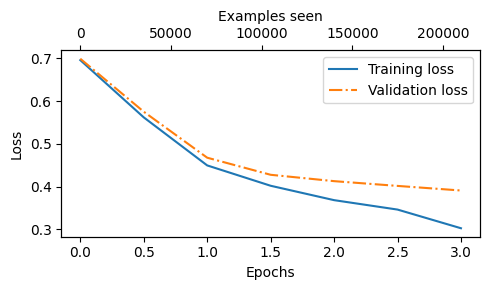

In [126]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)
# graph looks good, it should fall steeply and then flatten

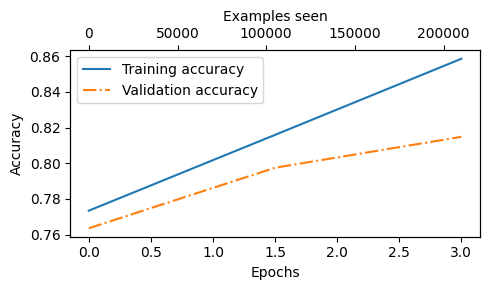

In [127]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [128]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 85.89%
Validation accuracy: 81.54%
Test accuracy: 81.84%


In [129]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad(): # we're not training anymore (...)
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "democrat" if predicted_label == 1 else "republican"

In [137]:
text_1 = ("Many Immigrants are criminals")
print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))

text_2 = ("Universal healthcare is needed")
print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

republican
democrat


In [131]:
text_3 = ("Trump is a great president")
print(classify_review(text_3, model, tokenizer, device, max_length=train_dataset.max_length))

republican


Important obersvation: The model is not very good at identifying "casual" texts, it's really optimized towards the poltical tweets!

In [132]:
def evaluate_tweets(df, model, tokenizer, device, max_length=169, pad_token_id=50256, num_tweets=None):
    # Ensure model is in evaluation mode
    model.eval()

    # Create copies to avoid modifying original dataframe
    results = df.copy()

    # Limit number of tweets if specified
    if num_tweets is not None:
        results = results.head(num_tweets)  # Use .sample() instead of .head() for random selection

    # Convert labels to human-readable strings if needed (assuming 0=republican, 1=democrat)
    if results['labels'].dtype != object:
        results['actual'] = results['labels'].apply(lambda x: "democrat" if x == 1 else "republican")
    else:
        results['actual'] = results['labels']

    # Classify tweets
    results['predicted'] = results['text'].apply(
        lambda x: classify_review(
            text=x,
            model=model,
            tokenizer=tokenizer,
            device=device,
            max_length=max_length,
            pad_token_id=pad_token_id
        )
    )

    # Calculate accuracy
    accuracy = (results['predicted'] == results['actual']).mean()

    # Generate confusion matrix
    conf_matrix = pd.crosstab(results['actual'], results['predicted'],
                            rownames=['Actual'], colnames=['Predicted'])

    # Calculate class-wise metrics
    report = classification_report(results['actual'], results['predicted'])

    return results, accuracy, conf_matrix, report

In [133]:
# Usage example:
from sklearn.metrics import classification_report

# Run evaluation
results_df, accuracy, conf_matrix, report = evaluate_tweets(
    df=remaining_df,
    model=model,
    tokenizer=tokenizer,
    device=device,
    num_tweets=100
)

# Print results
print(f"Model Accuracy: {accuracy:.2%}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)


Model Accuracy: 77.00%

Confusion Matrix:
Predicted   democrat  republican
Actual                          
democrat          41          14
republican         9          36

Classification Report:
              precision    recall  f1-score   support

    democrat       0.82      0.75      0.78        55
  republican       0.72      0.80      0.76        45

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.78      0.77      0.77       100



In [134]:
# Optional: Show some misclassified examples
misclassified = results_df[results_df['predicted'] != results_df['actual']]
print(f"\nSample of {min(10, len(misclassified))} misclassified tweets:")
for idx, row in misclassified.head(10).iterrows():
    print(f"\nTweet: {row['text']}")
    print(f"Actual: {row['actual']}, Predicted: {row['predicted']}")


Sample of 10 misclassified tweets:

Tweet: The Commonwealth is receiving another $3,457,425.36 from the .@fema to cover costs of responding to the COVID-19 pa… https://t.co/RGnQsDpEJw
Actual: democrat, Predicted: republican

Tweet: MT's extreme drought conditions are threatening the livelihoods of rural MT communities and  devastating MT ag operations. @RepRosendale and I are pushing @JoeBiden to allow grazing within the Charles M. Russell Wildlife Refuge to help relieve our ranchers and landscapes.
Actual: republican, Predicted: democrat

Tweet: Pleased to present the 2022 Congressional Fire and Rescue and Emergency Medical Services (EMS) Awards to 14 of our… https://t.co/CpjvsJYzBr
Actual: republican, Predicted: democrat

Tweet: House Republicans are committed to protecting and strengthening Social Security for current beneficiaries and futur… https://t.co/uDSNY0pjXD
Actual: republican, Predicted: democrat

Tweet: Unacceptable. Numerous Senators working to fix this as we speak. I ju

In [135]:
"""
from google.colab import drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/tweet_party_classifier.pth"
torch.save(model.state_dict(), save_path)
"""

MessageError: Error: credential propagation was unsuccessful